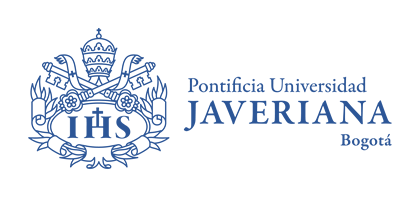

#**Proyecto Grafos - Tópicos Avanzados Analítica**

###**Realizado por:**

- Adrián Esquinas
- Carlos Másmela
- Yudy Pedraza
- Daniela Zarate

###**Resumen:**

El siguiente Notebook tiene como propósito mostrar la solución al problema de clasificación de usuarios que emplean lenguaje explícito y un sistema de recomendación de usuarios, mediante **Grafos** con base en lo aprendido en la clase de tópicos avanzados para analítica.


# **0. Librerías**

A continuación se presentan las librerías empleadas para la solución del ejercicio

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

from torch_geometric.datasets import Twitch #Dataset seleccionado

%matplotlib inline

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

# **1. Lectura de data**

En las siguientes líneas se realiza la lectura de la data.

Se lee el modelo

In [ ]:
dataset = Twitch(root='.', name="ES" ) #Se analizará sobre Twitch en Español

Processing...
Done!


Se revisa los nodos y conexiones del modelo.

In [ ]:
[print(idx, i) for idx, i in enumerate(dataset)] #Se busca los datasets que hay dentro de la librería

0 Data(x=[4648, 128], edge_index=[2, 123412], y=[4648])


[None]

In [ ]:
data = dataset[0] # Se selecciona el dataset

Se leen las conexiones entre cada nodo

In [ ]:
df = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])
print(f"Se tienen: {len(df)} conexiones\n")
df.head()

Se tienen: 123412 conexiones



,start_node,end_node
0,0,1819
1,1819,0
2,0,2840
3,2840,0
4,1819,3


In [ ]:
# Información básica del dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Caracteristacas de cada nodo
print(f'Number of classes: {dataset.num_classes}\t\t(Explicit Languaje),(Non Explicit Language)') #Clases a predecir - usuario usa lenguaje inapropiado o no

# Información de la grafica
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Twitch()
-----------------------
Number of graphs: 1
Number of features: 128
Number of classes: 2		(Explicit Languaje),(Non Explicit Language)

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


Se lee el grafo mediante la librería de networkx

In [ ]:
G = nx.from_pandas_edgelist(df, "start_node", "end_node")

Se realiza una visualización inicial aleatoria

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 9))
# ax.axis("off")
# plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
# nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

Se realiza una visualización con Spring Layout

In [ ]:
# pos = nx.spring_layout(G, iterations=40, seed=1721)
# fig, ax = plt.subplots(figsize=(15, 9))
# ax.axis("off")
# nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

# **2. Análisis descriptivo**

En la siguientes líneas de código podrá encontrar todo el análisis descriptivo del gráfico en cuestión

# **3. Prepraración de la data**

En las siguientes líneas se podrá observar los diversos métodos con los cuales fueron traducidos los grafos a números para que puedan ser entendidos por los modelos

## ***3.1 Matriz de Adyacencia***

In [ ]:
edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

In [ ]:
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency.cpu().numpy()

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 2.]], dtype=float32)

## ***3.2 Node2Vec***

In [ ]:
!pip install node2vec
!pip install -q node2vec
#!pip install -qI gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)

def next_node(previous, current, p, q):
    alphas = []

    # Get the neighboring nodes
    neighbors = list(G.neighbors(current))

    # Calculate the appropriate alpha value for each neighbor
    for neighbor in neighbors:
        # Distance = 0: probability to return to the previous node
        if neighbor == previous:
            alpha = 1/p
        # Distance = 1: probability of visiting a local node
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # Distance = 2: probability to explore an unknown node
        else:
            alpha = 1/q
        alphas.append(alpha)

    # Normalize the alpha values to create transition probabilities
    probs = [alpha / sum(alphas) for alpha in alphas]

    # Randomly select the new node based on the transition probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [ ]:
def random_walk(start, length, p, q):
    walk = [start]

    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)

    return walk

Se debe activa GPU para que crgue rápido el código

In [ ]:
import gensim
import networkx as nx
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random

walks = []
num_walks = 1
walk_length = 10
p = 2.0
q = 3

for _ in range(num_walks):
    for node in G.nodes:
        walk = random_walk(node, walk_length, p, q)
        walks.append(walk)

# Create and train Word2Vec for DeepWalk
node2vec = Word2Vec(walks,
                hs=1,   # Hierarchical softmax
                sg=1,   # Skip-gram
                vector_size=100,
                window=10,
                workers=2,
                min_count=1,
                seed=0)
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

(1493231, 1533840)

In [ ]:
node_count = node2vec.corpus_count
embedding_size = node2vec.vector_size
print('Número de nodos:', node_count)
print('Tamaño del embedding:', embedding_size)

Número de nodos: 4648
Tamaño del embedding: 100


# **4. Modelación**

A continuación se presenta la modelación al problema planteado, dentro del cual se tiene:
- Sistema de recomendación
- Clasificación de usuarios para saber si emplean lenguaje explícito o no, mediante:

    1.   Regresión Logística
    2.   Random Forest
    3.   XGBoost
    4.   Red Neuronal
    5.   CNN
    6.   Modelos de atención



## ***4.1 Sistema de recomendación***

## ***4.2 Clasificación de usuarios con lenguaje explícito***

### *4.2.1 Regresión Logística*

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
rl_param_grid = ParameterGrid(
    {
    'penalty': ['l1','l2'],
    'C': [0.01, 0.1, 0.2, 0.5, 1, 2],
    'max_iter': [1000, 2000],
}
)

#### **Funcion Regresion Logistica**

In [ ]:
def reg_log(X_train, y_train, X_val, y_val) -> dict:
  # Loop para ajustar un modelo con cada combinación de hiperparámetros
  resultados_rl = {'params': [], 'Accuracy': [], 'F1': []}

  #Se entrena el modelo con x y y train
  #Se mira calidad del resultado con el set de validación
  for params in rl_param_grid:
        rl = LogisticRegression(
            random_state=42,
            solver= 'saga',
            **params)
        rl.fit(X_train, y_train)
        y_pred = rl.predict(X_val)
        resultados_rl['params'].append(params)
        resultados_rl['Accuracy'].append(accuracy_score(y_val, y_pred))
        resultados_rl['F1'].append(f1_score(y_val, y_pred))

        print(f"Modelo: {params} \u2713")
  return resultados_rl

In [ ]:
def evaluar_mejor_solucion_reg_log(X_train, y_train, X_test, y_test, params: dict) -> None:
  rl = LogisticRegression(
            random_state=42,
            solver= 'saga',
            **params)
  rl.fit(X_train, y_train)
  y_pred = rl.predict(X_test)
  print(f"La solución obtuvo un F1 Score y Accuracy en la data de prueba de:\nF1: {f1_score(y_test, y_pred)}\nAccuracy: {accuracy_score(y_test, y_pred)}")

#### **X por default del dataset**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = data.x.cpu().numpy()

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
resultados_rl = reg_log(X_train, y_train, X_val, y_val)

Modelo: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 0.01, 'max_iter': 1000, 'penalty': None} ✓
Modelo: {'C': 0.01, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.01, 'max_iter': 2000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Modelo: {'C': 0.01, 'max_iter': 2000, 'penalty': None} ✓
Modelo: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 0.1, 'max_iter': 1000, 'penalty': None} ✓
Modelo: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Modelo: {'C': 0.1, 'max_iter': 2000, 'penalty': None} ✓
Modelo: {'C': 0.2, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.2, 'max_iter': 1000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 0.2, 'max_iter': 1000, 'penalty': None} ✓
Modelo: {'C': 0.2, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.2, 'max_iter': 2000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Modelo: {'C': 0.2, 'max_iter': 2000, 'penalty': None} ✓
Modelo: {'C': 0.5, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.5, 'max_iter': 1000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 0.5, 'max_iter': 1000, 'penalty': None} ✓
Modelo: {'C': 0.5, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.5, 'max_iter': 2000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Modelo: {'C': 0.5, 'max_iter': 2000, 'penalty': None} ✓
Modelo: {'C': 1, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 1, 'max_iter': 1000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 1, 'max_iter': 1000, 'penalty': None} ✓
Modelo: {'C': 1, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 1, 'max_iter': 2000, 'penalty': 'l2'} ✓
Modelo: {'C': 1, 'max_iter': 2000, 'penalty': None} ✓
Modelo: {'C': 2, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 2, 'max_iter': 1000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 2, 'max_iter': 1000, 'penalty': None} ✓
Modelo: {'C': 2, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 2, 'max_iter': 2000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Modelo: {'C': 2, 'max_iter': 2000, 'penalty': None} ✓


In [ ]:
# Resultados
resultados_rlt = pd.DataFrame(resultados_rl)
resultados_rlt = pd.concat([resultados_rlt['params'].apply(pd.Series), resultados_rlt], axis=1)
resultados_rlt = resultados_rlt.drop(columns = 'params')
resultados_rlt = resultados_rlt.sort_values('Accuracy', ascending=False)
resultados_rlt.head()

,C,max_iter,penalty,Accuracy,F1
15,0.20,2000.0,l1,0.718280,0.268156
12,0.20,1000.0,l1,0.718280,0.268156
0,0.01,1000.0,l1,0.716129,0.000000
3,0.01,2000.0,l1,0.716129,0.000000
9,0.10,2000.0,l1,0.713978,0.248588


In [ ]:
params = {'penalty': 'l1', 'C': 0.2, 'max_iter': 2000}
evaluar_mejor_solucion_reg_log(X_train, y_train, X_test, y_test, params)

La solución obtuvo un F1 Score y Accuracy en la data de prueba de:
F1: 0.23728813559322035
Accuracy: 0.7096774193548387


#### **Matriz de adyacencia**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = adjacency.cpu().numpy()

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
resultados_rl = reg_log(X_train, y_train, X_val, y_val)

Modelo: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'} ✓
Modelo: {'C': 0.01, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.01, 'max_iter': 2000, 'penalty': 'l2'} ✓
Modelo: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'} ✓
Modelo: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2'} ✓
Modelo: {'C': 0.2, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.2, 'max_iter': 1000, 'penalty': 'l2'} ✓
Modelo: {'C': 0.2, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.2, 'max_iter': 2000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 0.5, 'max_iter': 1000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.5, 'max_iter': 1000, 'penalty': 'l2'} ✓
Modelo: {'C': 0.5, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 0.5, 'max_iter': 2000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 1, 'max_iter': 1000, 'penalty': 'l1'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 1, 'max_iter': 1000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 1, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 1, 'max_iter': 2000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 2, 'max_iter': 1000, 'penalty': 'l1'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 2, 'max_iter': 1000, 'penalty': 'l2'} ✓


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo: {'C': 2, 'max_iter': 2000, 'penalty': 'l1'} ✓
Modelo: {'C': 2, 'max_iter': 2000, 'penalty': 'l2'} ✓


In [ ]:
# Resultados
resultados_rlt = pd.DataFrame(resultados_rl)
resultados_rlt = pd.concat([resultados_rlt['params'].apply(pd.Series), resultados_rlt], axis=1)
resultados_rlt = resultados_rlt.drop(columns = 'params')
resultados_rlt = resultados_rlt.sort_values('Accuracy', ascending=False)
resultados_rlt.head()

,C,max_iter,penalty,Accuracy,F1
3,0.01,2000,l2,0.752688,0.285714
1,0.01,1000,l2,0.752688,0.285714
13,0.50,1000,l2,0.739785,0.476190
15,0.50,2000,l2,0.739785,0.476190
5,0.10,1000,l2,0.737634,0.401961


In [ ]:
params = {'penalty': 'l2', 'C': 0.01, 'max_iter': 2000}
evaluar_mejor_solucion_reg_log(X_train, y_train, X_test, y_test, params)

La solución obtuvo un F1 Score y Accuracy en la data de prueba de:
F1: 0.21794871794871795
Accuracy: 0.7376344086021506


#### **Node2Vec**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = node2vec.wv

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

### *4.2.2 Random Forest*

#### **X por default del dataset**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = data.x.cpu().numpy()

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

#### **Matriz de adyacencia**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = adjacency.cpu().numpy()

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

#### **Node2Vec**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = node2vec.wv

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

### *4.2.3 SVM*

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Hiperparametros a probar
svm_grid = ParameterGrid({
    'kernel': ['linear', 'rbf'],  #kernels que desea probar
    'C': [0.5, 0.7], # Una lista con los valores de C para regularización
    'gamma': [1.3, 1.5] #valores de gamma de los kernels
})

#### **Función Support Vector Machine**

In [ ]:
def support_vector_machine(X_train, y_train, X_val, y_val) -> dict:
  # Loop para ajustar un modelo con cada combinación de hiperparámetros
  resultados_svm = {'params': [], 'Accuracy': [], 'F1': []}

  #Se entrena el modelo con x y y train
  #Se mira calidad del resultado con el set de validación
  for params in svm_grid:
        svm = SVC(
            random_state= 42,
            ** params
            )
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_val)
        resultados_svm['params'].append(params)
        resultados_svm['Accuracy'].append(accuracy_score(y_val, y_pred))
        resultados_svm['F1'].append(f1_score(y_val, y_pred))

        print(f"Modelo: {params} \u2713")

  return resultados_svm

In [ ]:
def evaluar_mejor_solucion_svm(X_train, y_train, X_test, y_test, params: dict) -> None:
  svm = SVC(
            random_state= 42,
            ** params
            )
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_test)
  print(f"La solución obtuvo un F1 Score y Accuracy en la data de prueba de:\nF1: {f1_score(y_test, y_pred)}\nAccuracy: {accuracy_score(y_test, y_pred)}")

#### **X por default del dataset**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = data.x.cpu().numpy()

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
resultados_svm = support_vector_machine(X_train, y_train, X_val, y_val)

Modelo: {'C': 0.5, 'gamma': 1.3, 'kernel': 'linear'} ✓
Modelo: {'C': 0.5, 'gamma': 1.3, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.5, 'gamma': 1.5, 'kernel': 'linear'} ✓
Modelo: {'C': 0.5, 'gamma': 1.5, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.7, 'gamma': 1.3, 'kernel': 'linear'} ✓
Modelo: {'C': 0.7, 'gamma': 1.3, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.7, 'gamma': 1.5, 'kernel': 'linear'} ✓
Modelo: {'C': 0.7, 'gamma': 1.5, 'kernel': 'rbf'} ✓


In [ ]:
# Resultados
resultados_svmt = pd.DataFrame(resultados_svm)
resultados_svmt = pd.concat([resultados_svmt['params'].apply(pd.Series), resultados_svmt], axis=1)
resultados_svmt = resultados_svmt.drop(columns = 'params')
resultados_svmt = resultados_svmt.sort_values('Accuracy', ascending=False)
resultados_svmt.head()

,C,gamma,kernel,Accuracy,F1
1,0.5,1.3,rbf,0.716129,0.000000
3,0.5,1.5,rbf,0.716129,0.000000
5,0.7,1.3,rbf,0.716129,0.000000
7,0.7,1.5,rbf,0.716129,0.000000
0,0.5,1.3,linear,0.707527,0.081081


In [ ]:
params = {'kernel': 'rbf', 'C': 0.5, 'gamma': 1.3}
evaluar_mejor_solucion_svm(X_train, y_train, X_test, y_test, params)

La solución obtuvo un F1 Score y Accuracy en la data de prueba de:
F1: 0.0
Accuracy: 0.7096774193548387


#### **Matriz de adyacencia**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = adjacency.cpu().numpy()

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
resultados_svm = support_vector_machine(X_train, y_train, X_val, y_val)

Modelo: {'C': 0.5, 'gamma': 1.3, 'kernel': 'linear'} ✓
Modelo: {'C': 0.5, 'gamma': 1.3, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.5, 'gamma': 1.5, 'kernel': 'linear'} ✓
Modelo: {'C': 0.5, 'gamma': 1.5, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.7, 'gamma': 1.3, 'kernel': 'linear'} ✓
Modelo: {'C': 0.7, 'gamma': 1.3, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.7, 'gamma': 1.5, 'kernel': 'linear'} ✓
Modelo: {'C': 0.7, 'gamma': 1.5, 'kernel': 'rbf'} ✓


In [ ]:
# Resultados
resultados_svmt = pd.DataFrame(resultados_svm)
resultados_svmt = pd.concat([resultados_svmt['params'].apply(pd.Series), resultados_svmt], axis=1)
resultados_svmt = resultados_svmt.drop(columns = 'params')
resultados_svmt = resultados_svmt.sort_values('Accuracy', ascending=False)
resultados_svmt.head()

,C,gamma,kernel,Accuracy,F1
1,0.5,1.3,rbf,0.716129,0.000000
3,0.5,1.5,rbf,0.716129,0.000000
5,0.7,1.3,rbf,0.716129,0.000000
7,0.7,1.5,rbf,0.716129,0.000000
0,0.5,1.3,linear,0.668817,0.437956


In [ ]:
params = {'kernel': 'rbf', 'C': 0.5, 'gamma': 1.3}
evaluar_mejor_solucion_svm(X_train, y_train, X_test, y_test, params)

La solución obtuvo un F1 Score y Accuracy en la data de prueba de:
F1: 0.0
Accuracy: 0.7096774193548387


#### **Node2Vec**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = node2vec.wv

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
resultados_svm = support_vector_machine(X_train, y_train, X_val, y_val)

Modelo: {'C': 0.5, 'gamma': 1.3, 'kernel': 'linear'} ✓
Modelo: {'C': 0.5, 'gamma': 1.3, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.5, 'gamma': 1.5, 'kernel': 'linear'} ✓
Modelo: {'C': 0.5, 'gamma': 1.5, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.7, 'gamma': 1.3, 'kernel': 'linear'} ✓
Modelo: {'C': 0.7, 'gamma': 1.3, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.7, 'gamma': 1.5, 'kernel': 'linear'} ✓
Modelo: {'C': 0.7, 'gamma': 1.5, 'kernel': 'rbf'} ✓


In [ ]:
# Resultados
resultados_svmt = pd.DataFrame(resultados_svm)
resultados_svmt = pd.concat([resultados_svmt['params'].apply(pd.Series), resultados_svmt], axis=1)
resultados_svmt = resultados_svmt.drop(columns = 'params')
resultados_svmt = resultados_svmt.sort_values('Accuracy', ascending=False)
resultados_svmt.head()

,C,gamma,kernel,Accuracy,F1
0,0.5,1.3,linear,0.716129,0.0
1,0.5,1.3,rbf,0.716129,0.0
2,0.5,1.5,linear,0.716129,0.0
3,0.5,1.5,rbf,0.716129,0.0
4,0.7,1.3,linear,0.716129,0.0


In [ ]:
params = {'kernel': 'linear', 'C': 0.5, 'gamma': 1.3}
evaluar_mejor_solucion_svm(X_train, y_train, X_test, y_test, params)

La solución obtuvo un F1 Score y Accuracy en la data de prueba de:
F1: 0.0
Accuracy: 0.7096774193548387


### *4.2.4 XGBoost*

In [ ]:
from xgboost import XGBClassifier, plot_importance

Parámetros sobre los que se optimizará el XGBoost - Aplica para todos

In [ ]:
xgb_param_grid = ParameterGrid(
    {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, None],
    'n_estimators': [50, 100, 200],
    'subsample': [ 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
    }
)

#### **X por default del dataset**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = data.x.cpu().numpy()

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

Se genera el XGBoost

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros

resultados_xgb = {'params': [], 'Accuracy': [], 'F1': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación
for params in xgb_param_grid:
      xgb = XGBClassifier(
          eval_metric='mlogloss',
          random_state= 42,
          ** params
          )
      xgb.fit(X_train, y_train)
      y_pred = xgb.predict(X_val)
      resultados_xgb['params'].append(params)
      resultados_xgb['Accuracy'].append(accuracy_score(y_val, y_pred))
      resultados_xgb['F1'].append(f1_score(y_val, y_pred))

      print(f"Modelo: {params} \u2713")


Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100

Se miran resultados del modelo

In [ ]:
# Resultados
resultados_xgbt = pd.DataFrame(resultados_xgb)
resultados_xgbt = pd.concat([resultados_xgbt['params'].apply(pd.Series), resultados_xgbt], axis=1)
resultados_xgbt = resultados_xgbt.drop(columns = 'params')
resultados_xgbt=resultados_xgbt.sort_values('F1', ascending=False)
resultados_xgbt.head()

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,Accuracy,F1
46,0.5,0.2,5.0,200.0,0.7,0.711828,0.355769
92,0.7,0.2,3.0,100.0,0.7,0.739785,0.345946
38,0.5,0.2,3.0,100.0,0.7,0.726882,0.341969
22,0.5,0.1,3.0,200.0,0.7,0.731183,0.338624
40,0.5,0.2,3.0,200.0,0.7,0.711828,0.336634


Se prueba mejor solucion en test

In [ ]:
params = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.5} #mejores hiperparametros
xgb = XGBClassifier(
          eval_metric='mlogloss',
          random_state= 42,
          ** params
          )
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f"La solución obtuvo un F1 Score y Accuracy en la data de prueba de:\nF1: {f1_score(y_test, y_pred)}\nAccuracy: {accuracy_score(y_test, y_pred)}")


La solución obtuvo un F1 Score y Accuracy en la data de prueba de:
F1: 0.3557692307692307
Accuracy: 0.7118279569892473


#### **Matriz de Adyacencia**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = adjacency.cpu().numpy()

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

Se genera el XGBoost

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros

resultados_xgb = {'params': [], 'Accuracy': [], 'F1': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación
for params in xgb_param_grid:
      xgb = XGBClassifier(
          eval_metric='mlogloss',
          random_state= 42,
          ** params
          )
      xgb.fit(X_train, y_train)
      y_pred = xgb.predict(X_val)
      resultados_xgb['params'].append(params)
      resultados_xgb['Accuracy'].append(accuracy_score(y_val, y_pred))
      resultados_xgb['F1'].append(f1_score(y_val, y_pred))

      print(f"Modelo: {params} \u2713")


Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100

Se miran resultados del modelo

In [ ]:
# Resultados
resultados_xgbt = pd.DataFrame(resultados_xgb)
resultados_xgbt = pd.concat([resultados_xgbt['params'].apply(pd.Series), resultados_xgbt], axis=1)
resultados_xgbt = resultados_xgbt.drop(columns = 'params')
resultados_xgbt=resultados_xgbt.sort_values('Accuracy', ascending=False)
resultados_xgbt.head()

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,Accuracy,F1
84,0.7,0.1,NaN,50.0,0.7,0.759140,0.410526
25,0.5,0.1,5.0,50.0,1.0,0.752688,0.364641
90,0.7,0.2,3.0,50.0,0.7,0.752688,0.397906
151,1.0,0.2,5.0,50.0,1.0,0.752688,0.416244
27,0.5,0.1,5.0,100.0,1.0,0.752688,0.422111


Se prueba mejor solucion en test

In [ ]:
params = {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 50, 'subsample': 0.7, 'colsample_bytree': 0.7} #mejores hiperparametros
xgb = XGBClassifier(
          eval_metric='mlogloss',
          random_state= 42,
          ** params
          )
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f"La solución obtuvo un F1 Score y Accuracy en la data de prueba de:\nF1: {f1_score(y_test, y_pred)}\nAccuracy: {accuracy_score(y_test, y_pred)}")


La solución obtuvo un F1 Score y Accuracy en la data de prueba de:
F1: 0.27058823529411763
Accuracy: 0.7333333333333333


#### **Node2Vec**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = node2vec.wv

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

Se genera el XGBoost

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros

resultados_xgb = {'params': [], 'Accuracy': [], 'F1': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación
for params in xgb_param_grid:
      xgb = XGBClassifier(
          eval_metric='mlogloss',
          random_state= 42,
          ** params
          )
      xgb.fit(X_train, y_train)
      y_pred = xgb.predict(X_val)
      resultados_xgb['params'].append(params)
      resultados_xgb['Accuracy'].append(accuracy_score(y_val, y_pred))
      resultados_xgb['F1'].append(f1_score(y_val, y_pred))

      print(f"Modelo: {params} \u2713")


Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0} ✓
Modelo: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100

Se miran resultados del modelo

In [ ]:
# Resultados
resultados_xgbt = pd.DataFrame(resultados_xgb)
resultados_xgbt = pd.concat([resultados_xgbt['params'].apply(pd.Series), resultados_xgbt], axis=1)
resultados_xgbt = resultados_xgbt.drop(columns = 'params')
resultados_xgbt=resultados_xgbt.sort_values('Accuracy', ascending=False)
resultados_xgbt.head()

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,Accuracy,F1
81,0.7,0.1,5.0,100.0,1.0,0.731183,0.260355
83,0.7,0.1,5.0,200.0,1.0,0.731183,0.301676
45,0.5,0.2,5.0,100.0,1.0,0.731183,0.293785
132,1.0,0.1,5.0,50.0,0.7,0.731183,0.213836
141,1.0,0.1,NaN,100.0,1.0,0.726882,0.248521


Se prueba mejor solucion en test

In [ ]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0, 'colsample_bytree': 0.7} #mejores hiperparametros
xgb = XGBClassifier(
          eval_metric='mlogloss',
          random_state= 42,
          ** params
          )
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f"La solución obtuvo un F1 Score y Accuracy en la data de prueba de:\nF1: {f1_score(y_test, y_pred)}\nAccuracy: {accuracy_score(y_test, y_pred)}")


La solución obtuvo un F1 Score y Accuracy en la data de prueba de:
F1: 0.1818181818181818
Accuracy: 0.7096774193548387


### *4.2.5 Red Neuronal*

In [ ]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F

In [ ]:
ann_param_grid = ParameterGrid(
    {
    'activacion': ["relu", "tanh"],
    'dropout': [0.4, 0.5, 0.6],
    }
)
capas = [[32, 0], [32, 16]]

#### **Clase red neuronal**

Se genera la función para calcular el accuracy

In [ ]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

Clase de red neuronal

In [ ]:
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_h_2=0, dim_out=1):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        if dim_h_2 > 0:
          self.linear2 = Linear(dim_h, dim_h_2)
          self.linear3 = Linear(dim_h_2, dim_out)
          self.capas = 3
        else:
          self.linear2 = Linear(dim_h, dim_out)
          self.capas = 2

    def forward(self, x, activacion, dropout):

        if activacion == "relu":
          x = self.linear1(x)
          x = torch.relu(x)
          x = F.dropout(x, p=dropout, training=self.training)
          x = self.linear2(x)
          if self.capas > 2:
            x = torch.relu(x)
            x = F.dropout(x, p=dropout, training=self.training)
            x = self.linear3(x)
          return F.log_softmax(x, dim=1)

        elif activacion == "tanh":
          x = self.linear1(x)
          x = torch.tanh(x)
          x = F.dropout(x, p=dropout, training=self.training)
          x = self.linear2(x)
          if self.capas > 2:
            x = torch.tanh(x)
            x = F.dropout(x, p=dropout, training=self.training)
            x = self.linear3(x)
          return F.log_softmax(x, dim=1)

    def fit(self, data, y, train_mask, val_mask, epochs, activacion, dropout):
        criterion = torch.nn.CrossEntropyLoss() #Se requiere binary cross entropy
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data, activacion, dropout) #llama instancia forward
            loss = criterion(out[train_mask], y[train_mask])
            acc = accuracy(out[train_mask].argmax(dim=1),
                          y[train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[val_mask], y[val_mask])
                val_acc = accuracy(out[val_mask].argmax(dim=1),
                                  y[val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data, y, test_mask, activacion, dropout):
        self.eval()
        out = self(data, activacion, dropout)
        acc = accuracy(out.argmax(dim=1)[test_mask], y[test_mask])
        return acc

#### **X por default del dataset**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = data.x.cpu().numpy()

df_sep = pd.DataFrame(X)

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X=data.x #Tener el X como tensor para poder usar en pytorch

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_ann = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:

  #Conocer cuantas capas tiene la iteración en cuestión
  num_cap = 0
  for neuronas in capa:
    if neuronas > 0:
        num_cap += 1

  for params in ann_param_grid:
    mlp = MLP(dataset.num_features, capa[0], capa[1], dataset.num_classes)
    print(mlp)

    # Train
    mlp.fit(X, y, index_train, index_val, epochs=200, **params)

    # Test
    acc = mlp.test(X, y, index_test, **params)
    resultados_ann['params'].append(params)
    resultados_ann['Accuracy en test'].append(acc.item())
    resultados_ann['Capas Ocultas'].append(num_cap)

    print(f"Modelo: {params} \u2713\n")

MLP(
  (linear1): Linear(in_features=128, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.701 | Train Acc: 53.66% | Val Loss: 0.72 | Val Acc: 48.82%
Epoch  20 | Train Loss: 0.508 | Train Acc: 75.36% | Val Loss: 0.60 | Val Acc: 69.25%
Epoch  40 | Train Loss: 0.451 | Train Acc: 79.40% | Val Loss: 0.64 | Val Acc: 69.89%
Epoch  60 | Train Loss: 0.402 | Train Acc: 81.15% | Val Loss: 0.73 | Val Acc: 71.83%
Epoch  80 | Train Loss: 0.377 | Train Acc: 83.06% | Val Loss: 0.79 | Val Acc: 68.17%
Epoch 100 | Train Loss: 0.357 | Train Acc: 84.35% | Val Loss: 0.88 | Val Acc: 67.10%
Epoch 120 | Train Loss: 0.333 | Train Acc: 85.45% | Val Loss: 0.91 | Val Acc: 65.81%
Epoch 140 | Train Loss: 0.316 | Train Acc: 85.53% | Val Loss: 0.82 | Val Acc: 69.89%
Epoch 160 | Train Loss: 0.290 | Train Acc: 87.60% | Val Loss: 0.89 | Val Acc: 67.74%
Epoch 180 | Train Loss: 0.287 | Train Acc: 87.31% | Val Loss: 0.99 | Val Acc: 65.38%
Epoch 200 | Tra

In [ ]:
# Resultados
resultados_annt = pd.DataFrame(resultados_ann)
resultados_annt = pd.concat([resultados_annt['params'].apply(pd.Series), resultados_annt], axis=1)
resultados_annt = resultados_annt.drop(columns = 'params')
resultados_annt = resultados_annt.sort_values('Accuracy en test', ascending=False)
resultados_annt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
3,tanh,0.4,1,0.722581
5,tanh,0.6,1,0.718280
4,tanh,0.5,1,0.716129


#### **Matriz de adyacencia**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = adjacency.cpu().numpy()

df_sep = pd.DataFrame(X)

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X = adjacency

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_ann = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:

  #Conocer cuantas capas tiene la iteración en cuestión
  num_cap = 0
  for neuronas in capa:
    if neuronas > 0:
        num_cap += 1

  for params in ann_param_grid:
    mlp = MLP(len(X[1]), capa[0], capa[1], dataset.num_classes)
    print(mlp)

    # Train
    mlp.fit(X, y, index_train, index_val, epochs=200, **params)

    # Test
    acc = mlp.test(X, y, index_test, **params)
    resultados_ann['params'].append(params)
    resultados_ann['Accuracy en test'].append(acc.item())
    resultados_ann['Capas Ocultas'].append(num_cap)

    print(f"Modelo: {params} \u2713\n")

MLP(
  (linear1): Linear(in_features=4648, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.710 | Train Acc: 30.26% | Val Loss: 0.71 | Val Acc: 27.10%
Epoch  20 | Train Loss: 0.125 | Train Acc: 97.04% | Val Loss: 0.77 | Val Acc: 68.39%
Epoch  40 | Train Loss: 0.052 | Train Acc: 99.44% | Val Loss: 0.94 | Val Acc: 69.25%
Epoch  60 | Train Loss: 0.041 | Train Acc: 99.76% | Val Loss: 0.92 | Val Acc: 69.03%
Epoch  80 | Train Loss: 0.035 | Train Acc: 99.70% | Val Loss: 0.97 | Val Acc: 69.46%
Epoch 100 | Train Loss: 0.031 | Train Acc: 99.76% | Val Loss: 1.15 | Val Acc: 67.10%
Epoch 120 | Train Loss: 0.032 | Train Acc: 99.68% | Val Loss: 1.01 | Val Acc: 67.96%
Epoch 140 | Train Loss: 0.027 | Train Acc: 99.65% | Val Loss: 1.10 | Val Acc: 66.67%
Epoch 160 | Train Loss: 0.032 | Train Acc: 99.60% | Val Loss: 1.08 | Val Acc: 69.03%
Epoch 180 | Train Loss: 0.031 | Train Acc: 99.41% | Val Loss: 1.08 | Val Acc: 66.45%
Epoch 200 | Tr

In [ ]:
# Resultados
resultados_annt = pd.DataFrame(resultados_ann)
resultados_annt = pd.concat([resultados_annt['params'].apply(pd.Series), resultados_annt], axis=1)
resultados_annt = resultados_annt.drop(columns = 'params')
resultados_annt = resultados_annt.sort_values('Accuracy en test', ascending=False)
resultados_annt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
8,relu,0.6,2,0.724731
2,relu,0.6,1,0.711828
1,relu,0.5,1,0.709677


#### **Node2Vec**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

embeddings_dict = {word: node2vec.wv[word] for word in node2vec.wv.index_to_key}
df_sep = pd.DataFrame.from_dict(embeddings_dict, orient="index").sort_index()

y = data.y
X = df_sep.values

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X = torch.from_numpy(df_sep.values)

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_ann = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:

  #Conocer cuantas capas tiene la iteración en cuestión
  num_cap = 0
  for neuronas in capa:
    if neuronas > 0:
        num_cap += 1

  for params in ann_param_grid:
    mlp = MLP(len(X[1]), capa[0], capa[1], dataset.num_classes)
    print(mlp)

    # Train
    mlp.fit(X, y, index_train, index_val, epochs=200, **params)

    # Test
    acc = mlp.test(X, y, index_test, **params)
    resultados_ann['params'].append(params)
    resultados_ann['Accuracy en test'].append(acc.item())
    resultados_ann['Capas Ocultas'].append(num_cap)

    print(f"Modelo: {params} \u2713\n")

MLP(
  (linear1): Linear(in_features=100, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.709 | Train Acc: 44.46% | Val Loss: 0.71 | Val Acc: 47.53%
Epoch  20 | Train Loss: 0.575 | Train Acc: 71.52% | Val Loss: 0.58 | Val Acc: 71.61%
Epoch  40 | Train Loss: 0.540 | Train Acc: 73.80% | Val Loss: 0.59 | Val Acc: 71.40%
Epoch  60 | Train Loss: 0.508 | Train Acc: 75.47% | Val Loss: 0.62 | Val Acc: 70.54%
Epoch  80 | Train Loss: 0.476 | Train Acc: 77.51% | Val Loss: 0.63 | Val Acc: 68.82%
Epoch 100 | Train Loss: 0.452 | Train Acc: 78.86% | Val Loss: 0.69 | Val Acc: 69.03%
Epoch 120 | Train Loss: 0.449 | Train Acc: 79.61% | Val Loss: 0.71 | Val Acc: 68.60%
Epoch 140 | Train Loss: 0.412 | Train Acc: 80.74% | Val Loss: 0.76 | Val Acc: 67.53%
Epoch 160 | Train Loss: 0.385 | Train Acc: 82.46% | Val Loss: 0.77 | Val Acc: 66.88%
Epoch 180 | Train Loss: 0.387 | Train Acc: 81.44% | Val Loss: 0.80 | Val Acc: 67.53%
Epoch 200 | Tra

In [ ]:
# Resultados
resultados_annt = pd.DataFrame(resultados_ann)
resultados_annt = pd.concat([resultados_annt['params'].apply(pd.Series), resultados_annt], axis=1)
resultados_annt = resultados_annt.drop(columns = 'params')
resultados_annt = resultados_annt.sort_values('Accuracy en test', ascending=False)
resultados_annt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
9,tanh,0.4,2,0.729032
1,relu,0.5,1,0.726882
3,tanh,0.4,1,0.722581


### *4.2.6 GCN*

In [ ]:
from torch_geometric.nn import GCNConv

In [ ]:
gcn_param_grid = ParameterGrid(
    {
    'activacion': ["relu", "tanh"],
    'dropout': [0.4, 0.5, 0.6],
    }
)
capas = [3, 4]

#### **Clase GCN**

In [ ]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out, capas_conv):
      super().__init__()
      if capas_conv == 3:
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)
      elif capas_conv == 4:
        self.gcn1 = GCNConv(dim_in, dim_h*8)
        self.gcn2 = GCNConv(dim_h*8, dim_h*4)
        self.gcn3 = GCNConv(dim_h*4, dim_h*2)
        self.gcn4 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index, capas_conv, activacion, dropout):
      if capas_conv == 3:
        if activacion == "relu":
          h = self.gcn1(x, edge_index)
          h = torch.relu(h)
          h = F.dropout(h, p=dropout, training=self.training)
          h = self.gcn2(h, edge_index)
          h = torch.relu(h)
          h = F.dropout(h, p=dropout, training=self.training)
          h = self.gcn3(h, edge_index)
          h = torch.relu(h)
          h = self.linear(h)
          return h
        if activacion == "tanh":
          h = self.gcn1(x, edge_index)
          h = torch.tanh(h)
          h = F.dropout(h, p=dropout, training=self.training)
          h = self.gcn2(h, edge_index)
          h = torch.tanh(h)
          h = F.dropout(h, p=dropout, training=self.training)
          h = self.gcn3(h, edge_index)
          h = torch.tanh(h)
          h = self.linear(h)
          return h
      elif capas_conv == 4:
        if activacion == "relu":
          h = self.gcn1(x, edge_index)
          h = torch.relu(h)
          h = F.dropout(h, p=dropout, training=self.training)
          h = self.gcn2(h, edge_index)
          h = torch.relu(h)
          h = F.dropout(h, p=dropout, training=self.training)
          h = self.gcn3(h, edge_index)
          h = torch.relu(h)
          h = self.gcn4(h, edge_index)
          h = torch.relu(h)
          h = self.linear(h)
          return h
        if activacion == "tanh":
          h = self.gcn1(x, edge_index)
          h = torch.tanh(h)
          h = F.dropout(h, p=dropout, training=self.training)
          h = self.gcn2(h, edge_index)
          h = torch.tanh(h)
          h = F.dropout(h, p=dropout, training=self.training)
          h = self.gcn3(h, edge_index)
          h = torch.tanh(h)
          h = self.gcn4(h, edge_index)
          h = torch.tanh(h)
          h = self.linear(h)
          return h

    def fit(self, data, y, edge_index, train_mask, val_mask, epochs, capas_conv, activacion, dropout):
        criterion = torch.nn.CrossEntropyLoss() #Se requiere binary cross entropy
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data, edge_index, capas_conv, activacion, dropout) #llama instancia forward
            loss = criterion(out[train_mask], y[train_mask])
            acc = accuracy(out[train_mask].argmax(dim=1),
                          y[train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[val_mask], y[val_mask])
                val_acc = accuracy(out[val_mask].argmax(dim=1),
                                  y[val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data, y, edge_index, test_mask, capas_conv, activacion, dropout):
        self.eval()
        out = self(data, edge_index, capas_conv, activacion, dropout)
        acc = accuracy(out.argmax(dim=1)[test_mask], y[test_mask])
        return acc


#### **X por default del dataset**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = data.x.cpu().numpy()

df_sep = pd.DataFrame(X)

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X=data.x #Tener el X como tensor para poder usar en pytorch

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_gcn = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:
  for params in gcn_param_grid:
    gcn = GCN(len(X[1]), 16, dataset.num_classes, capa)
    print(gcn)

    # Train
    gcn.fit(X, y, data.edge_index, index_train, index_val, epochs=100, capas_conv=capa, **params)

    # Test
    acc = gcn.test(X, y, data.edge_index, index_test, capas_conv=capa, **params)

    resultados_gcn['params'].append(params)
    resultados_gcn['Accuracy en test'].append(acc.item())
    resultados_gcn['Capas Ocultas'].append(capa)

    print(f"Modelo: {params} \u2713\n")

GCN(
  (gcn1): GCNConv(128, 64)
  (gcn2): GCNConv(64, 32)
  (gcn3): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.700 | Train Acc: 33.35% | Val Loss: 0.70 | Val Acc: 34.19%
Epoch  20 | Train Loss: 0.569 | Train Acc: 70.60% | Val Loss: 0.57 | Val Acc: 71.61%
Epoch  40 | Train Loss: 0.533 | Train Acc: 71.36% | Val Loss: 0.55 | Val Acc: 72.47%
Epoch  60 | Train Loss: 0.516 | Train Acc: 73.53% | Val Loss: 0.57 | Val Acc: 72.47%
Epoch  80 | Train Loss: 0.482 | Train Acc: 75.74% | Val Loss: 0.56 | Val Acc: 75.27%
Epoch 100 | Train Loss: 0.464 | Train Acc: 76.79% | Val Loss: 0.57 | Val Acc: 73.98%
Modelo: {'activacion': 'relu', 'dropout': 0.4} ✓

GCN(
  (gcn1): GCNConv(128, 64)
  (gcn2): GCNConv(64, 32)
  (gcn3): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.669 | Train Acc: 70.47% | Val Loss: 0.67 | Val Acc: 71.40%
Epoch  20 | Train Loss: 0.563 | Train Acc: 70.60% | Val Los

In [ ]:
# Resultados
resultados_gcnt = pd.DataFrame(resultados_gcn)
resultados_gcnt = pd.concat([resultados_gcnt['params'].apply(pd.Series), resultados_gcnt], axis=1)
resultados_gcnt = resultados_gcnt.drop(columns = 'params')
resultados_gcnt = resultados_gcnt.sort_values('Accuracy en test', ascending=False)
resultados_gcnt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
7,relu,0.5,4,0.741935
6,relu,0.4,4,0.737634
2,relu,0.6,3,0.733333


#### **Matriz de adyacencia**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = adjacency.cpu().numpy()

df_sep = pd.DataFrame(X)

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X = adjacency

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_gcn = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:
  for params in gcn_param_grid:
    gcn = GCN(len(X[1]), 16, dataset.num_classes, capa)
    print(gcn)

    # Train
    gcn.fit(X, y, data.edge_index, index_train, index_val, epochs=100, capas_conv=capa, **params)

    # Test
    acc = gcn.test(X, y, data.edge_index, index_test, capas_conv=capa, **params)

    resultados_gcn['params'].append(params)
    resultados_gcn['Accuracy en test'].append(acc.item())
    resultados_gcn['Capas Ocultas'].append(capa)

    print(f"Modelo: {params} \u2713\n")

GCN(
  (gcn1): GCNConv(4648, 64)
  (gcn2): GCNConv(64, 32)
  (gcn3): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.650 | Train Acc: 70.60% | Val Loss: 0.65 | Val Acc: 71.61%
Epoch  20 | Train Loss: 0.576 | Train Acc: 71.44% | Val Loss: 0.56 | Val Acc: 71.83%
Epoch  40 | Train Loss: 0.545 | Train Acc: 73.13% | Val Loss: 0.54 | Val Acc: 75.91%
Epoch  60 | Train Loss: 0.543 | Train Acc: 72.73% | Val Loss: 0.54 | Val Acc: 75.05%
Epoch  80 | Train Loss: 0.526 | Train Acc: 73.83% | Val Loss: 0.53 | Val Acc: 76.34%
Epoch 100 | Train Loss: 0.515 | Train Acc: 74.74% | Val Loss: 0.54 | Val Acc: 74.84%
Modelo: {'activacion': 'relu', 'dropout': 0.4} ✓

GCN(
  (gcn1): GCNConv(4648, 64)
  (gcn2): GCNConv(64, 32)
  (gcn3): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.693 | Train Acc: 62.40% | Val Loss: 0.69 | Val Acc: 63.01%
Epoch  20 | Train Loss: 0.565 | Train Acc: 71.33% | Val L

In [ ]:
# Resultados
resultados_gcnt = pd.DataFrame(resultados_gcn)
resultados_gcnt = pd.concat([resultados_gcnt['params'].apply(pd.Series), resultados_gcnt], axis=1)
resultados_gcnt = resultados_gcnt.drop(columns = 'params')
resultados_gcnt = resultados_gcnt.sort_values('Accuracy en test', ascending=False)
resultados_gcnt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
1,relu,0.5,3,0.746237
5,tanh,0.6,3,0.744086
6,relu,0.4,4,0.744086


#### **Node2Vec**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

embeddings_dict = {word: node2vec.wv[word] for word in node2vec.wv.index_to_key}
df_sep = pd.DataFrame.from_dict(embeddings_dict, orient="index").sort_index()

y = data.y
X = df_sep.values

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X = torch.from_numpy(df_sep.values)

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_gcn = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:
  for params in gcn_param_grid:
    gcn = GCN(len(X[1]), 16, dataset.num_classes, capa)
    print(gcn)

    # Train
    gcn.fit(X, y, data.edge_index, index_train, index_val, epochs=100, capas_conv=capa, **params)

    # Test
    acc = gcn.test(X, y, data.edge_index, index_test, capas_conv=capa, **params)

    resultados_gcn['params'].append(params)
    resultados_gcn['Accuracy en test'].append(acc.item())
    resultados_gcn['Capas Ocultas'].append(capa)

    print(f"Modelo: {params} \u2713\n")

GCN(
  (gcn1): GCNConv(100, 64)
  (gcn2): GCNConv(64, 32)
  (gcn3): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.707 | Train Acc: 30.80% | Val Loss: 0.71 | Val Acc: 32.04%
Epoch  20 | Train Loss: 0.589 | Train Acc: 70.60% | Val Loss: 0.58 | Val Acc: 71.61%
Epoch  40 | Train Loss: 0.566 | Train Acc: 70.60% | Val Loss: 0.57 | Val Acc: 71.61%
Epoch  60 | Train Loss: 0.558 | Train Acc: 71.79% | Val Loss: 0.55 | Val Acc: 73.55%
Epoch  80 | Train Loss: 0.541 | Train Acc: 72.86% | Val Loss: 0.54 | Val Acc: 75.27%
Epoch 100 | Train Loss: 0.534 | Train Acc: 73.40% | Val Loss: 0.54 | Val Acc: 74.62%
Modelo: {'activacion': 'relu', 'dropout': 0.4} ✓

GCN(
  (gcn1): GCNConv(100, 64)
  (gcn2): GCNConv(64, 32)
  (gcn3): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=2, bias=True)
)
Epoch   0 | Train Loss: 0.635 | Train Acc: 70.60% | Val Loss: 0.63 | Val Acc: 71.61%
Epoch  20 | Train Loss: 0.565 | Train Acc: 72.30% | Val Los

In [ ]:
# Resultados
resultados_gcnt = pd.DataFrame(resultados_gcn)
resultados_gcnt = pd.concat([resultados_gcnt['params'].apply(pd.Series), resultados_gcnt], axis=1)
resultados_gcnt = resultados_gcnt.drop(columns = 'params')
resultados_gcnt = resultados_gcnt.sort_values('Accuracy en test', ascending=False)
resultados_gcnt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
2,relu,0.6,3,0.752688
1,relu,0.5,3,0.750538
5,tanh,0.6,3,0.750538


### *4.2.7 Modelos de Atención*

In [ ]:
from torch_geometric.nn import GATv2Conv, GCNConv

In [ ]:
gat_param_grid = ParameterGrid(
    {
    'activacion': ["elu", "relu"],
    'dropout': [0.4, 0.5, 0.6],
    }
)
capas = [2, 3, 4]

#### **Clase GAT**

In [ ]:
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, capas_, heads=16):
    super().__init__()
    if capas_ == 2:
      self.gat1 = GATv2Conv(dim_in, dim_h, heads=int(heads/2))
      self.gat2 = GATv2Conv(dim_h*int(heads/2), dim_out, heads=1)
    elif capas_ == 3:
      self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
      self.gat2 = GATv2Conv(dim_h*heads, dim_h, heads=int(heads/2))
      self.gat3 = GATv2Conv(dim_h*int(heads/2), dim_out, heads=1)
    elif capas_ == 4:
      self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
      self.gat2 = GATv2Conv(dim_h*heads, dim_h, heads=int(heads/2))
      self.gat3 = GATv2Conv(dim_h*int(heads/2), dim_h, heads=int(heads/4))
      self.gat4 = GATv2Conv(dim_h*int(heads/4), dim_out, heads=1)

  def forward(self, x, edge_index, capas_, activacion, dropout):
    if capas_ == 2:
      if activacion == 'elu':
        h = F.dropout(x, p=dropout, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
      elif activacion == 'relu':
        h = F.dropout(x, p=dropout, training=self.training)
        h = self.gat1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
    if capas_ == 3:
      if activacion == 'elu':
        h = F.dropout(x, p=dropout, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat2(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat3(h, edge_index)
        return F.log_softmax(h, dim=1)
      elif activacion == 'relu':
        h = F.dropout(x, p=dropout, training=self.training)
        h = self.gat1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat3(h, edge_index)
        return F.log_softmax(h, dim=1)
    if capas_ == 4:
      if activacion == 'elu':
        h = F.dropout(x, p=dropout, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat2(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat3(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat4(h, edge_index)
        return F.log_softmax(h, dim=1)
      elif activacion == 'relu':
        h = F.dropout(x, p=dropout, training=self.training)
        h = self.gat1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat3(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=dropout, training=self.training)
        h = self.gat4(h, edge_index)
        return F.log_softmax(h, dim=1)

  def fit(self, data, y, edge_index, train_mask, val_mask, epochs, capas_, activacion, dropout):
        criterion = torch.nn.CrossEntropyLoss() #Se requiere binary cross entropy
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data, edge_index, capas_, activacion, dropout) #llama instancia forward
            loss = criterion(out[train_mask], y[train_mask])
            acc = accuracy(out[train_mask].argmax(dim=1),
                          y[train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[val_mask], y[val_mask])
                val_acc = accuracy(out[val_mask].argmax(dim=1),
                                  y[val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

  @torch.no_grad()
  def test(self, data, y, edge_index, test_mask, capas_, activacion, dropout):
      self.eval()
      out = self(data, edge_index, capas_, activacion, dropout)
      acc = accuracy(out.argmax(dim=1)[test_mask], y[test_mask])
      return acc

#### **X por default del dataset**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = data.x.cpu().numpy()

df_sep = pd.DataFrame(X)

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X=data.x #Tener el X como tensor para poder usar en pytorch

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_gat = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:
  for params in gat_param_grid:
    gat = GAT(len(X[1]), 16, dataset.num_classes, capa)
    print(gat)

    # Train
    gat.fit(X, y, data.edge_index, index_train, index_val, epochs=100, capas_=capa, **params)

    # Test
    acc = gat.test(X, y, data.edge_index, index_test, capas_=capa, **params)

    resultados_gat['params'].append(params)
    resultados_gat['Accuracy en test'].append(acc.item())
    resultados_gat['Capas Ocultas'].append(capa)

    print(f"Modelo: {params} \u2713\n")

GAT(
  (gat1): GATv2Conv(128, 16, heads=8)
  (gat2): GATv2Conv(128, 2, heads=1)
)
Epoch   0 | Train Loss: 0.656 | Train Acc: 65.49% | Val Loss: 0.65 | Val Acc: 65.38%
Epoch  20 | Train Loss: 0.580 | Train Acc: 70.44% | Val Loss: 0.56 | Val Acc: 71.40%
Epoch  40 | Train Loss: 0.549 | Train Acc: 72.67% | Val Loss: 0.56 | Val Acc: 74.84%
Epoch  60 | Train Loss: 0.534 | Train Acc: 73.53% | Val Loss: 0.54 | Val Acc: 76.13%
Epoch  80 | Train Loss: 0.530 | Train Acc: 74.13% | Val Loss: 0.57 | Val Acc: 72.90%
Epoch 100 | Train Loss: 0.525 | Train Acc: 73.70% | Val Loss: 0.54 | Val Acc: 74.19%
Modelo: {'activacion': 'elu', 'dropout': 0.4} ✓

GAT(
  (gat1): GATv2Conv(128, 16, heads=8)
  (gat2): GATv2Conv(128, 2, heads=1)
)
Epoch   0 | Train Loss: 0.952 | Train Acc: 37.55% | Val Loss: 0.95 | Val Acc: 36.13%
Epoch  20 | Train Loss: 0.576 | Train Acc: 70.95% | Val Loss: 0.58 | Val Acc: 72.90%
Epoch  40 | Train Loss: 0.563 | Train Acc: 70.90% | Val Loss: 0.56 | Val Acc: 71.18%
Epoch  60 | Train Loss

In [ ]:
# Resultados
resultados_gatt = pd.DataFrame(resultados_gat)
resultados_gatt = pd.concat([resultados_gatt['params'].apply(pd.Series), resultados_gatt], axis=1)
resultados_gatt = resultados_gatt.drop(columns = 'params')
resultados_gatt = resultados_gatt.sort_values('Accuracy en test', ascending=False)
resultados_gatt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
10,relu,0.5,3,0.737634
9,relu,0.4,3,0.735484
2,elu,0.6,2,0.735484


#### **Matriz de adyacencia**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

y = data.y
X = adjacency.cpu().numpy()

df_sep = pd.DataFrame(X)

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X = adjacency

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_gat = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:
  for params in gat_param_grid:
    gat = GAT(len(X[1]), 16, dataset.num_classes, capa)
    print(gat)

    # Train
    gat.fit(X, y, data.edge_index, index_train, index_val, epochs=100, capas_=capa, **params)

    # Test
    acc = gat.test(X, y, data.edge_index, index_test, capas_=capa, **params)

    resultados_gat['params'].append(params)
    resultados_gat['Accuracy en test'].append(acc.item())
    resultados_gat['Capas Ocultas'].append(capa)

    print(f"Modelo: {params} \u2713\n")

GAT(
  (gat1): GATv2Conv(4648, 16, heads=8)
  (gat2): GATv2Conv(128, 2, heads=1)
)
Epoch   0 | Train Loss: 0.692 | Train Acc: 51.48% | Val Loss: 0.69 | Val Acc: 53.12%
Epoch  20 | Train Loss: 0.563 | Train Acc: 72.46% | Val Loss: 0.58 | Val Acc: 72.26%
Epoch  40 | Train Loss: 0.516 | Train Acc: 74.48% | Val Loss: 0.54 | Val Acc: 73.76%
Epoch  60 | Train Loss: 0.467 | Train Acc: 77.78% | Val Loss: 0.56 | Val Acc: 74.41%
Epoch  80 | Train Loss: 0.402 | Train Acc: 81.28% | Val Loss: 0.58 | Val Acc: 74.41%
Epoch 100 | Train Loss: 0.370 | Train Acc: 83.46% | Val Loss: 0.65 | Val Acc: 69.25%
Modelo: {'activacion': 'elu', 'dropout': 0.4} ✓

GAT(
  (gat1): GATv2Conv(4648, 16, heads=8)
  (gat2): GATv2Conv(128, 2, heads=1)
)
Epoch   0 | Train Loss: 0.672 | Train Acc: 65.14% | Val Loss: 0.67 | Val Acc: 67.96%
Epoch  20 | Train Loss: 0.566 | Train Acc: 71.60% | Val Loss: 0.57 | Val Acc: 71.18%
Epoch  40 | Train Loss: 0.528 | Train Acc: 73.96% | Val Loss: 0.55 | Val Acc: 73.55%
Epoch  60 | Train Lo

In [ ]:
# Resultados
resultados_gatt = pd.DataFrame(resultados_gat)
resultados_gatt = pd.concat([resultados_gatt['params'].apply(pd.Series), resultados_gatt], axis=1)
resultados_gatt = resultados_gatt.drop(columns = 'params')
resultados_gatt = resultados_gatt.sort_values('Accuracy en test', ascending=False)
resultados_gatt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
4,relu,0.5,2,0.744086
1,elu,0.5,2,0.741935
15,relu,0.4,4,0.731183


#### **Node2Vec**

In [ ]:
#Se crea división entre variable de respuesta y las demás variables

embeddings_dict = {word: node2vec.wv[word] for word in node2vec.wv.index_to_key}
df_sep = pd.DataFrame.from_dict(embeddings_dict, orient="index").sort_index()

y = data.y
X = df_sep.values

# Se separa train, validación y test (80% train, 10% validacion, 10% test)
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(df_sep, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


index_train = torch.from_numpy(np.array([True if pos in X_train.index else False for pos in range(len(X))])) #mascara train
index_val = torch.from_numpy(np.array([True if pos in X_val.index else False for pos in range(len(X))])) #mascara validación
index_test = torch.from_numpy(np.array([True if pos in X_test.index else False for pos in range(len(X))])) #mascara test

X = torch.from_numpy(df_sep.values)

In [ ]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados_gat = {'params': [], 'Capas Ocultas': [], 'Accuracy en test': []}

#Se entrena el modelo con x y y train
#Se mira calidad del resultado con el set de validación

for capa in capas:
  for params in gat_param_grid:
    gat = GAT(len(X[1]), 16, dataset.num_classes, capa)
    print(gat)

    # Train
    gat.fit(X, y, data.edge_index, index_train, index_val, epochs=100, capas_=capa, **params)

    # Test
    acc = gat.test(X, y, data.edge_index, index_test, capas_=capa, **params)

    resultados_gat['params'].append(params)
    resultados_gat['Accuracy en test'].append(acc.item())
    resultados_gat['Capas Ocultas'].append(capa)

    print(f"Modelo: {params} \u2713\n")

GAT(
  (gat1): GATv2Conv(100, 16, heads=8)
  (gat2): GATv2Conv(128, 2, heads=1)
)
Epoch   0 | Train Loss: 0.719 | Train Acc: 47.28% | Val Loss: 0.72 | Val Acc: 46.67%
Epoch  20 | Train Loss: 0.576 | Train Acc: 70.76% | Val Loss: 0.57 | Val Acc: 71.61%
Epoch  40 | Train Loss: 0.563 | Train Acc: 71.52% | Val Loss: 0.56 | Val Acc: 73.55%
Epoch  60 | Train Loss: 0.552 | Train Acc: 72.70% | Val Loss: 0.55 | Val Acc: 72.47%
Epoch  80 | Train Loss: 0.545 | Train Acc: 72.65% | Val Loss: 0.55 | Val Acc: 72.04%
Epoch 100 | Train Loss: 0.547 | Train Acc: 72.38% | Val Loss: 0.56 | Val Acc: 74.19%
Modelo: {'activacion': 'elu', 'dropout': 0.4} ✓

GAT(
  (gat1): GATv2Conv(100, 16, heads=8)
  (gat2): GATv2Conv(128, 2, heads=1)
)
Epoch   0 | Train Loss: 0.896 | Train Acc: 33.16% | Val Loss: 0.91 | Val Acc: 31.18%
Epoch  20 | Train Loss: 0.593 | Train Acc: 70.79% | Val Loss: 0.59 | Val Acc: 72.26%
Epoch  40 | Train Loss: 0.566 | Train Acc: 71.33% | Val Loss: 0.56 | Val Acc: 73.76%
Epoch  60 | Train Loss

In [ ]:
# Resultados
resultados_gatt = pd.DataFrame(resultados_gat)
resultados_gatt = pd.concat([resultados_gatt['params'].apply(pd.Series), resultados_gatt], axis=1)
resultados_gatt = resultados_gatt.drop(columns = 'params')
resultados_gatt = resultados_gatt.sort_values('Accuracy en test', ascending=False)
resultados_gatt.head(3)

,activacion,dropout,Capas Ocultas,Accuracy en test
3,relu,0.4,2,0.737634
4,relu,0.5,2,0.733333
9,relu,0.4,3,0.729032
